In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split

from library.Data_Preprocessing import Balance_Ratio, training_def
from library.Imbalance_Sampling import label_divide, resampling_dataset
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## Function Definition

### XGBoost

In [2]:
# classifier
def XGBoostC(train_x, test_x, train_y, test_y, config, return_prob = False):
    
    clf = xgb.XGBClassifier(**config, n_jobs = -1, use_label_encoder = False)
    clf.fit(train_x, train_y)
    predict_y = clf.predict_proba(test_x)[:, 1]
    define_predict = (predict_y > 0.5).astype(int)
    if return_prob:
        result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    else:
        result = pd.DataFrame({'truth': test_y, 'predict': define_predict})
    
    return result
    

# regressor (optional)
def XGBoostR(train_x, test_x, train_y, test_y, config):
    
    reg = xgb.XGBRegressor(**config, n_jobs = -1)
    reg.fit(train_x, train_y)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})

    return result


# classifier for all resampling datasets
def runall_XGBoostC(trainset_x, test_x, trainset_y, test_y, config):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    set_index = list(config.keys())
    judge = set_index[0]

    for i, j in tqdm(enumerate(set_index)):
        print('\n', f'Data{j}:')
        if isinstance(config[judge], dict) :
            best_config = config[j]
        else :
            best_config = config
            
        result = XGBoostC(trainset_x[j], test_x, trainset_y[j], test_y, best_config)    
        table = cf_matrix(result, trainset_y[j])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'data{j}'})

    return table_set
    

# regressor for all resampling datasets (optional)
def runall_XGBoostR(num_set, trainset_x, test_x, trainset_y, test_y, config, thres_target = 'Recall', threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')

        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = XGBoostR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config)     
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})
        
    return pr_dict, table_set

### Optuna

In [3]:
# creator of optuna study for XGBoost
def XGBoost_creator(train_data, mode, num_valid = 5, label = 'GB') :
    
    def objective(trial) :

        param = {
            'eval_metric': trial.suggest_categorical('eval_metric', ['logloss']),
            'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500, 1000]),
            'subsample': trial.suggest_float('subsample', 0.3, 0.9, step = 0.2),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9, step = 0.2),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 11, step = 2),
            'max_depth': trial.suggest_int('max_depth', 3, 18, step = 3),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.325, step = 0.05),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10), # alpha
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10) # lambda
        }

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)

            if mode == 'C':
                result = XGBoostC(train_x, valid_x, train_y, valid_y, param)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                precision = table['Precision']
                beta = 1
                if recall.values > 0:
                    fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision)
                else:
                    fscore = 0
                result_list.append(fscore)

            elif mode == 'R':
                result = XGBoostR(train_x, valid_x, train_y, valid_y, param)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)
    
    return objective

### Full Experiment

In [4]:
def full_xgboost(train_month, times):
    best_param = dict()
    all_score = dict()
    prob_dict = dict()
    result_df = pd.DataFrame()

    # load relabel datasets
    runhist = {}
    kinds = {}
    for i in train_month:
        runhist[f'm{i}'] = pd.read_csv(f'relabel_runhist_m{i}.csv', index_col = 'id').iloc[:, 1:]
        kinds[f'm{i}'] = pd.read_csv(f'kind_m{i}.csv').iloc[:, 2:-3]

    #  do several times to average the random effect of resampling
    for i in tqdm(range(times)):
        # generate resampled datasets
        resampling_dataset(runhist = runhist, kinds = kinds, train_month = train_month, final_br = 1, num_os = 10)

        # load & prepare the resampled datasets 
        all_train = multiple_set(num_set = 10)
        all_train_x, all_train_y = train_set(all_train)
        all_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
        all_test_x, all_test_y = label_divide(all_test, None, 'GB', train_only = True)

        # searching for hyperparameters
        best_param[i], all_score[i] = all_optuna(all_data = all_train, 
                                         mode = 'C', 
                                         TPE_multi = False, 
                                         n_iter = 25, 
                                         filename = f'runhist_array_m2m4_m5_3criteria_XGBoost_{i}',
                                         creator = XGBoost_creator
                                        )
        # store the probability predicted by the classifier 
        for j in best_param[i].keys():
            if i == 0:
                prob_dict[j] = pd.DataFrame()
            table = XGBoostC(all_train_x[j], all_test_x, all_train_y[j], all_test_y, best_param[i][j], return_prob = True)
            prob_dict[j] = pd.concat([prob_dict[j], table[['predict']]], axis = 1)
            
    # average to get final prediction
    for j in best_param[0].keys():
        prediction = (prob_dict[j].apply(np.sum, axis = 1) >= 0.5).astype(int)
        result = pd.DataFrame(dict(truth = all_test_y, predict = prediction))
        table = cf_matrix(result, all_train_y[j])
        result_df = pd.concat([result_df, table]).rename(index = {0: f'data{j}'})
        
    return result_df

## Prediction

### Full Experiment

In [5]:
training_month = range(2, 5)
table_setC = full_xgboost(training_month, times = 3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 155
# over: 155
Size after Border: 39617

 Generating Dataset 2
Size after Undersampling: 1354
Size after Undersampling: (1354, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-09 00:15:26,198] A new study created in memory with name: no-name-6cece171-d4c4-4c7f-bd0d-fdbe12f9bd22


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9870298313878081 
Recall: 0.9921773142112125 
Aging Rate: 0.5026075619295959
Precision: 0.9882506527415144 
Recall: 0.9869621903520208 
Aging Rate: 0.49934810951760106
Precision: 0.9882352941176471 
Recall: 0.9856584093872229 
Aging Rate: 0.49869621903520206
[I 2022-05-09 00:15:30,780] Trial 0 finished with value: 0.9880493500270481 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 7.092880971144977, 'reg_lambda': 2.71743142924541}. Best is trial 0 with value: 0.9880493500270481.
Precision: 0.9744897959183674 
Recall: 0.9960886571056062 
Aging Rate: 0.5110821382007823
Precision: 0.983225806451613 
Recall: 0.9934810951760105 
Aging Rate: 0.5052151238591917
Precision: 0.9907773386034255 
Recall: 0.9804432855280313 
Aging Rate: 0.49478487614080835
[I 2022-05-09 00:15:35,902] Trial 1 finished with value: 0.9863603099585481 and para

Precision: 0.9693877551020408 
Recall: 0.9908735332464146 
Aging Rate: 0.5110821382007823
Precision: 0.9843953185955787 
Recall: 0.9869621903520208 
Aging Rate: 0.5013037809647979
Precision: 0.9741935483870968 
Recall: 0.984354628422425 
Aging Rate: 0.5052151238591917
[I 2022-05-09 00:16:15,771] Trial 13 finished with value: 0.9816459028201128 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 18, 'learning_rate': 0.125, 'reg_alpha': 0.03772881753992416, 'reg_lambda': 0.14627192130716313}. Best is trial 2 with value: 0.9911191955212114.
Precision: 0.9960886571056062 
Recall: 0.9960886571056062 
Aging Rate: 0.5
Precision: 0.9844760672703752 
Recall: 0.9921773142112125 
Aging Rate: 0.5039113428943938
Precision: 0.9895697522816167 
Recall: 0.9895697522816167 
Aging Rate: 0.5
[I 2022-05-09 00:16:21,241] Trial 14 finished with value: 0.9913233658996371 and parameters: {'eval_metric': 'logloss', 'n_es

[I 2022-05-09 00:16:59,340] A new study created in memory with name: no-name-a5fa63a6-2ae1-458c-bff4-c51b79372473


Precision: 0.9768934531450578 
Recall: 0.9921773142112125 
Aging Rate: 0.5078226857887875
[I 2022-05-09 00:16:59,278] Trial 24 finished with value: 0.987867321401497 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.325, 'reg_alpha': 0.019170603875873642, 'reg_lambda': 0.05528988038936743}. Best is trial 23 with value: 0.9917576964394446.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9010554089709762 
Recall: 0.9106666666666666 
Aging Rate: 0.5053333333333333
Precision: 0.9042690815006468 
Recall: 0.932 
Aging Rate: 0.5153333333333333
Precision: 0.9074315514993481 
Recall: 0.928 
Aging Rate: 0.5113333333333333
[I 2022-05-09 00:17:01,152] Trial 0 finished with value: 0.9137870729526457 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.3, 'colsample_bytree': 0.3, 'min_child_weight': 11, 'max_depth': 3, 'learning_rate': 0.275, 'reg_alpha': 3.615694568796086, 'reg_lambda': 0.054361422116436804}. Best is trial 0 with value: 0.9137870729526457.
Precision: 0.9367741935483871 
Recall: 0.968 
Aging Rate: 0.5166666666666667
Precision: 0.9423328964613368 
Recall: 0.9586666666666667 
Aging Rate: 0.5086666666666667
Precision: 0.9429312581063554 
Recall: 0.9693333333333334 
Aging Rate: 0.514
[I 2022-05-09 00:17:02,056] Trial 1 finished with value: 0.9528369301534529 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsamp

Precision: 0.9671484888304862 
Recall: 0.9813333333333333 
Aging Rate: 0.5073333333333333
Precision: 0.9879839786381842 
Recall: 0.9866666666666667 
Aging Rate: 0.49933333333333335
Precision: 0.9747003994673769 
Recall: 0.976 
Aging Rate: 0.5006666666666667
[I 2022-05-09 00:17:30,482] Trial 14 finished with value: 0.9789546429003502 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.3, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 1.387555399743877, 'reg_lambda': 0.8864962092712051}. Best is trial 12 with value: 0.9853863603716114.
Precision: 0.9827814569536424 
Recall: 0.9893333333333333 
Aging Rate: 0.5033333333333333
Precision: 0.9788639365918098 
Recall: 0.988 
Aging Rate: 0.5046666666666667
Precision: 0.9698952879581152 
Recall: 0.988 
Aging Rate: 0.5093333333333333
[I 2022-05-09 00:17:33,557] Trial 15 finished with value: 0.982773732684608 and parameters: {'eval_metric': 'logloss', 'n_estimators':

[I 2022-05-09 00:18:17,316] A new study created in memory with name: no-name-2e304865-07d5-4245-94a6-a619b675a43d


Precision: 0.9802890932982917 
Recall: 0.9946666666666667 
Aging Rate: 0.5073333333333333
[I 2022-05-09 00:18:17,254] Trial 24 finished with value: 0.9840666265923476 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.3, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.9686536129617231, 'reg_lambda': 1.3514647870268581}. Best is trial 21 with value: 0.9862884382811082.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9973009446693657 
Recall: 0.9723684210526315 
Aging Rate: 0.4875
Precision: 0.9973045822102425 
Recall: 0.9736842105263158 
Aging Rate: 0.4881578947368421
Precision: 0.9972789115646259 
Recall: 0.9644736842105263 
Aging Rate: 0.48355263157894735
[I 2022-05-09 00:18:18,251] Trial 0 finished with value: 0.9835439172057039 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.125, 'reg_alpha': 0.01689499907800358, 'reg_lambda': 0.025062509571314784}. Best is trial 0 with value: 0.9835439172057039.
Precision: 0.9931412894375857 
Recall: 0.9526315789473684 
Aging Rate: 0.47960526315789476
Precision: 0.9986206896551724 
Recall: 0.9526315789473684 
Aging Rate: 0.4769736842105263
Precision: 0.9918032786885246 
Recall: 0.9552631578947368 
Aging Rate: 0.48157894736842105
[I 2022-05-09 00:18:18,920] Trial 1 finished with value: 0.9735797550156168 and parameters: {'eval_metri

Precision: 1.0 
Recall: 0.9657894736842105 
Aging Rate: 0.48289473684210527
Precision: 0.997275204359673 
Recall: 0.9631578947368421 
Aging Rate: 0.48289473684210527
Precision: 0.9986357435197817 
Recall: 0.9631578947368421 
Aging Rate: 0.48223684210526313
[I 2022-05-09 00:18:57,705] Trial 13 finished with value: 0.9810309183448088 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.1409054141898985, 'reg_lambda': 2.1868616132764833}. Best is trial 5 with value: 0.9935992283031089.
Precision: 0.9959893048128342 
Recall: 0.9802631578947368 
Aging Rate: 0.4921052631578947
Precision: 1.0 
Recall: 0.9815789473684211 
Aging Rate: 0.49078947368421055
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
[I 2022-05-09 00:19:00,601] Trial 14 finished with value: 0.9900546459822944 and parameters: {'eval_metric':

[I 2022-05-09 00:19:40,386] A new study created in memory with name: no-name-f49db1a1-9faf-427a-9d92-1c72723a9053


Precision: 0.9986577181208054 
Recall: 0.9789473684210527 
Aging Rate: 0.4901315789473684
[I 2022-05-09 00:19:40,335] Trial 24 finished with value: 0.9876110030916604 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.325, 'reg_alpha': 0.06254581231371391, 'reg_lambda': 0.04760707503854651}. Best is trial 5 with value: 0.9935992283031089.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9773936170212766 
Recall: 0.9671052631578947 
Aging Rate: 0.49473684210526314
Precision: 0.9641909814323607 
Recall: 0.9565789473684211 
Aging Rate: 0.49605263157894736
Precision: 0.963254593175853 
Recall: 0.9657894736842105 
Aging Rate: 0.5013157894736842
[I 2022-05-09 00:19:41,050] Trial 0 finished with value: 0.965704157089597 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.325, 'reg_alpha': 0.13348610343571649, 'reg_lambda': 8.255237810269673}. Best is trial 0 with value: 0.965704157089597.
Precision: 0.9813084112149533 
Recall: 0.9671052631578947 
Aging Rate: 0.49276315789473685
Precision: 0.9932705248990579 
Recall: 0.9710526315789474 
Aging Rate: 0.4888157894736842
Precision: 0.9851351351351352 
Recall: 0.9592105263157895 
Aging Rate: 0.4868421052631579
[I 2022-05-09 00:19:44,133] Trial 1 finished with value: 0.9760636659087392 and parameters: {'eval

Precision: 0.9789473684210527 
Recall: 0.9789473684210527 
Aging Rate: 0.5
Precision: 0.9906417112299465 
Recall: 0.975 
Aging Rate: 0.4921052631578947
Precision: 0.9905913978494624 
Recall: 0.9697368421052631 
Aging Rate: 0.48947368421052634
[I 2022-05-09 00:20:29,964] Trial 13 finished with value: 0.9805863935333564 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'max_depth': 18, 'learning_rate': 0.125, 'reg_alpha': 0.29412505181692433, 'reg_lambda': 1.685019239752024}. Best is trial 10 with value: 0.9878874003889591.
Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
Precision: 0.9946949602122016 
Recall: 0.9868421052631579 
Aging Rate: 0.49605263157894736
Precision: 0.9894598155467721 
Recall: 0.9881578947368421 
Aging Rate: 0.4993421052631579
[I 2022-05-09 00:20:33,991] Trial 14 finished with value: 0.9903306179001503 and parameters: {'eval_metric': 'logloss', '

[I 2022-05-09 00:21:11,551] A new study created in memory with name: no-name-564fdba5-d94c-41b2-a630-30b47ee5ed21


Precision: 0.9933774834437086 
Recall: 0.9868421052631579 
Aging Rate: 0.4967105263157895
[I 2022-05-09 00:21:11,473] Trial 24 finished with value: 0.9890015122884321 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.125, 'reg_alpha': 0.06259286899911164, 'reg_lambda': 0.9587149493230303}. Best is trial 14 with value: 0.9903306179001503.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9624161073825503 
Recall: 0.9496688741721855 
Aging Rate: 0.49174917491749176
Precision: 0.9696969696969697 
Recall: 0.9748344370860927 
Aging Rate: 0.500990099009901
Precision: 0.9665327978580991 
Recall: 0.9562913907284768 
Aging Rate: 0.49306930693069306
[I 2022-05-09 00:21:13,909] Trial 0 finished with value: 0.963214579005477 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.3, 'colsample_bytree': 0.7, 'min_child_weight': 7, 'max_depth': 18, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.9208175686536295, 'reg_lambda': 0.011379816771231784}. Best is trial 0 with value: 0.963214579005477.
Precision: 0.9765319426336375 
Recall: 0.9920529801324504 
Aging Rate: 0.5062706270627063
Precision: 0.9855263157894737 
Recall: 0.9920529801324504 
Aging Rate: 0.5016501650165016
Precision: 0.9829172141918529 
Recall: 0.990728476821192 
Aging Rate: 0.5023102310231023
[I 2022-05-09 00:21:15,332] Trial 1 finished with value: 0.9866058467964063 and par

Precision: 0.993368700265252 
Recall: 0.9920529801324504 
Aging Rate: 0.4976897689768977
Precision: 0.9842312746386334 
Recall: 0.9920529801324504 
Aging Rate: 0.5023102310231023
Precision: 0.9855832241153342 
Recall: 0.9960264900662251 
Aging Rate: 0.5036303630363036
[I 2022-05-09 00:21:49,632] Trial 13 finished with value: 0.9905381306403873 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.275, 'reg_alpha': 0.040813129730592944, 'reg_lambda': 1.0575802145470041}. Best is trial 2 with value: 0.991849850655702.
Precision: 0.9776902887139107 
Recall: 0.9867549668874173 
Aging Rate: 0.502970297029703
Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
Precision: 0.9868766404199475 
Recall: 0.9960264900662251 
Aging Rate: 0.502970297029703
[I 2022-05-09 00:21:50,741] Trial 14 finished with value: 0.9890032173992761 and parameters: {'eva

[I 2022-05-09 00:22:15,474] A new study created in memory with name: no-name-d2001516-aaf8-4e7e-9461-3a4675dc9ad3


Precision: 0.993368700265252 
Recall: 0.9920529801324504 
Aging Rate: 0.4976897689768977
[I 2022-05-09 00:22:15,412] Trial 24 finished with value: 0.9942666062200521 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.275, 'reg_alpha': 0.4925424657011163, 'reg_lambda': 0.14791025907624003}. Best is trial 22 with value: 0.9949362887050648.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9595827900912647 
Recall: 0.983957219251337 
Aging Rate: 0.5086206896551724
Precision: 0.9774236387782205 
Recall: 0.983957219251337 
Aging Rate: 0.4993368700265252
Precision: 0.9722589167767504 
Recall: 0.983957219251337 
Aging Rate: 0.5019893899204244
[I 2022-05-09 00:22:17,616] Trial 0 finished with value: 0.9767899327952853 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.5, 'min_child_weight': 7, 'max_depth': 9, 'learning_rate': 0.325, 'reg_alpha': 0.2833628532025757, 'reg_lambda': 0.024893468050659673}. Best is trial 0 with value: 0.9767899327952853.
Precision: 0.9656538969616909 
Recall: 0.9772727272727273 
Aging Rate: 0.5019893899204244
Precision: 0.9707835325365206 
Recall: 0.9772727272727273 
Aging Rate: 0.4993368700265252
Precision: 0.9593175853018373 
Recall: 0.9772727272727273 
Aging Rate: 0.5053050397877984
[I 2022-05-09 00:22:18,977] Trial 1 finished with value: 0.9712192712479498 and parameters: {'eval_

Precision: 0.9865047233468286 
Recall: 0.9772727272727273 
Aging Rate: 0.49137931034482757
Precision: 0.9734395750332006 
Recall: 0.9799465240641712 
Aging Rate: 0.4993368700265252
Precision: 0.9775429326287979 
Recall: 0.9893048128342246 
Aging Rate: 0.5019893899204244
[I 2022-05-09 00:22:56,374] Trial 13 finished with value: 0.9806459803421964 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.225, 'reg_alpha': 3.735419436674568, 'reg_lambda': 0.6572195488895483}. Best is trial 12 with value: 0.9837070895845684.
Precision: 0.9620418848167539 
Recall: 0.982620320855615 
Aging Rate: 0.506631299734748
Precision: 0.9786950732356857 
Recall: 0.982620320855615 
Aging Rate: 0.4980106100795756
Precision: 0.9788359788359788 
Recall: 0.9893048128342246 
Aging Rate: 0.5013262599469496
[I 2022-05-09 00:22:58,781] Trial 14 finished with value: 0.9789728481977216 and parameters: {'eval

[I 2022-05-09 00:23:32,558] A new study created in memory with name: no-name-8b62f135-3c7c-419d-af2d-4b74b1266e30


Precision: 0.9852744310575636 
Recall: 0.983957219251337 
Aging Rate: 0.4953580901856764
[I 2022-05-09 00:23:32,464] Trial 24 finished with value: 0.9852883738588303 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.35747894812197634, 'reg_lambda': 2.919760089394862}. Best is trial 22 with value: 0.9877255542972665.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9904240766073872 
Recall: 0.9526315789473684 
Aging Rate: 0.48092105263157897
Precision: 0.9946164199192463 
Recall: 0.9723684210526315 
Aging Rate: 0.4888157894736842
Precision: 0.9904761904761905 
Recall: 0.9578947368421052 
Aging Rate: 0.48355263157894735
[I 2022-05-09 00:23:34,781] Trial 0 finished with value: 0.9761466462384284 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.225, 'reg_alpha': 2.725765219533383, 'reg_lambda': 0.4284745206879515}. Best is trial 0 with value: 0.9761466462384284.
Precision: 0.9835164835164835 
Recall: 0.9421052631578948 
Aging Rate: 0.4789473684210526
Precision: 0.9847009735744089 
Recall: 0.9315789473684211 
Aging Rate: 0.4730263157894737
Precision: 0.9889349930843707 
Recall: 0.9407894736842105 
Aging Rate: 0.4756578947368421
[I 2022-05-09 00:23:37,600] Trial 1 finished with value: 0.9613436247802817 and parameters: {'eva

Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
Precision: 0.9973368841544608 
Recall: 0.9855263157894737 
Aging Rate: 0.49407894736842106
Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
[I 2022-05-09 00:24:00,933] Trial 13 finished with value: 0.9898375466440731 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.275, 'reg_alpha': 0.07695707663560428, 'reg_lambda': 1.417030923639677}. Best is trial 13 with value: 0.9898375466440731.
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9946452476572959 
Recall: 0.9776315789473684 
Aging Rate: 0.49144736842105263
Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
[I 2022-05-09 00:24:03,391] Trial 14 finished with value: 0.9889595233573134 and parameters

[I 2022-05-09 00:24:58,159] A new study created in memory with name: no-name-c4345cd4-10e8-481c-a138-9943ce5b5e15


Precision: 0.9893899204244032 
Recall: 0.9815789473684211 
Aging Rate: 0.49605263157894736
[I 2022-05-09 00:24:58,066] Trial 24 finished with value: 0.9872102568388706 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.325, 'reg_alpha': 0.07478221298504928, 'reg_lambda': 3.083387219882745}. Best is trial 13 with value: 0.9898375466440731.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9798387096774194 
Recall: 0.9592105263157895 
Aging Rate: 0.48947368421052634
Precision: 0.9686274509803922 
Recall: 0.975 
Aging Rate: 0.5032894736842105
Precision: 0.9732262382864793 
Recall: 0.9565789473684211 
Aging Rate: 0.49144736842105263
[I 2022-05-09 00:25:00,581] Trial 0 finished with value: 0.9686829873179512 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.3, 'colsample_bytree': 0.5, 'min_child_weight': 7, 'max_depth': 12, 'learning_rate': 0.275, 'reg_alpha': 0.05309501107979086, 'reg_lambda': 0.03868630400118425}. Best is trial 0 with value: 0.9686829873179512.
Precision: 0.9919893190921228 
Recall: 0.9776315789473684 
Aging Rate: 0.49276315789473685
Precision: 0.9838926174496644 
Recall: 0.9644736842105263 
Aging Rate: 0.4901315789473684
Precision: 0.9892183288409704 
Recall: 0.9657894736842105 
Aging Rate: 0.4881578947368421
[I 2022-05-09 00:25:02,040] Trial 1 finished with value: 0.9787360040031237 and parameters: {'eval_metric

Precision: 0.9906666666666667 
Recall: 0.9776315789473684 
Aging Rate: 0.4934210526315789
Precision: 0.9905913978494624 
Recall: 0.9697368421052631 
Aging Rate: 0.48947368421052634
Precision: 0.997275204359673 
Recall: 0.9631578947368421 
Aging Rate: 0.48289473684210527
[I 2022-05-09 00:26:00,721] Trial 13 finished with value: 0.9813596101563739 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.125, 'reg_alpha': 0.16245062822157846, 'reg_lambda': 0.21365058670744663}. Best is trial 11 with value: 0.9870142923353198.
Precision: 0.9841269841269841 
Recall: 0.9789473684210527 
Aging Rate: 0.49736842105263157
Precision: 0.9854497354497355 
Recall: 0.9802631578947368 
Aging Rate: 0.49736842105263157
Precision: 0.9893899204244032 
Recall: 0.9815789473684211 
Aging Rate: 0.49605263157894736
[I 2022-05-09 00:26:09,400] Trial 14 finished with value: 0.983282967878807 and parameters

[I 2022-05-09 00:26:33,645] A new study created in memory with name: no-name-6d9c8492-06c1-4c5a-a286-d9f29ba4c300


Precision: 0.9893048128342246 
Recall: 0.9736842105263158 
Aging Rate: 0.4921052631578947
[I 2022-05-09 00:26:33,598] Trial 24 finished with value: 0.980849178356379 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.325, 'reg_alpha': 0.08699765950444942, 'reg_lambda': 0.011048139720485382}. Best is trial 11 with value: 0.9870142923353198.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9565217391304348 
Recall: 0.5789473684210527 
Aging Rate: 0.05502392344497608
Precision: 1.0 
Recall: 0.5789473684210527 
Aging Rate: 0.05263157894736842
Precision: 0.9696969696969697 
Recall: 0.42105263157894735 
Aging Rate: 0.039473684210526314
[I 2022-05-09 00:26:36,220] Trial 0 finished with value: 0.6806002573486406 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.025, 'reg_alpha': 0.018058546834632372, 'reg_lambda': 6.361136033181109}. Best is trial 0 with value: 0.6806002573486406.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 00:26:36,756] Trial 1 finished with value: 0.0 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.3, 'colsample_bytree': 0.7, 'min_child_weight': 11, 'max_depth': 6, 'learning_rate': 0.025, 'reg_alpha': 0.015939973690310045, 'reg_lambda': 0.0190499349795784}. Best is trial 0 with value: 0.6806002573486406.
Precision: 0.7931034482758621 
Recall: 0.3026315789473684 
Aging Rate: 0.034688995215311005
Precision: 0.8181818181818182 
Recall: 0.23684210526315788 
Aging Rate: 0.02631578947368421
Precision: 0.95 
Recall: 0.25 
Aging Rate: 0.023923444976076555
[I 2022-05-09 00:26:38,903] Trial 2 finished with value: 0.4004251700680272 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 1.1990867696311995, 'reg_lambda': 7.256110106635352}. Best is trial 0 with value: 0.6806002573486406

Precision: 0.9032258064516129 
Recall: 0.7368421052631579 
Aging Rate: 0.07416267942583732
[I 2022-05-09 00:27:22,664] Trial 14 finished with value: 0.8164187786552732 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 18, 'learning_rate': 0.275, 'reg_alpha': 0.3105644051023514, 'reg_lambda': 8.895975979035066}. Best is trial 6 with value: 0.8714239550608753.
Precision: 0.9487179487179487 
Recall: 0.4868421052631579 
Aging Rate: 0.04665071770334928
Precision: 0.9459459459459459 
Recall: 0.4605263157894737 
Aging Rate: 0.04425837320574163
Precision: 0.9722222222222222 
Recall: 0.4605263157894737 
Aging Rate: 0.0430622009569378
[I 2022-05-09 00:27:27,588] Trial 15 finished with value: 0.6293157624727459 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 150
# over: 150
Size after Border: 39625

 Generating Dataset 2
Size after Undersampling: 1370
Size after Undersampling: (1370, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-09 00:30:22,941] A new study created in memory with name: no-name-71913fd2-d62d-4ac9-83af-6ee0b62e1bf6


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9882659713168188 
Recall: 0.9882659713168188 
Aging Rate: 0.5
Precision: 0.9921976592977894 
Recall: 0.9947848761408083 
Aging Rate: 0.5013037809647979
Precision: 0.9960526315789474 
Recall: 0.9869621903520208 
Aging Rate: 0.4954367666232073
[I 2022-05-09 00:30:26,996] Trial 0 finished with value: 0.9910807098779267 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.275, 'reg_alpha': 0.03842046841661401, 'reg_lambda': 5.4086078231100965}. Best is trial 0 with value: 0.9910807098779267.
Precision: 0.990909090909091 
Recall: 0.9947848761408083 
Aging Rate: 0.5019556714471969
Precision: 0.9908854166666666 
Recall: 0.9921773142112125 
Aging Rate: 0.500651890482399
Precision: 0.9806949806949807 
Recall: 0.9934810951760105 
Aging Rate: 0.5065189048239895
[I 2022-05-09 00:30:35,481] Trial 1 finished with value: 0.9904735925969161 and parameters: {'eval_metric': 'logl

Precision: 0.9736147757255936 
Recall: 0.9621903520208605 
Aging Rate: 0.4941329856584094
Precision: 0.9713168187744459 
Recall: 0.9713168187744459 
Aging Rate: 0.5
Precision: 0.9630606860158312 
Recall: 0.9517601043024772 
Aging Rate: 0.4941329856584094
[I 2022-05-09 00:31:32,763] Trial 13 finished with value: 0.9655209068045968 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.275, 'reg_alpha': 7.888080627210161, 'reg_lambda': 1.960308373562173}. Best is trial 5 with value: 0.9913256039496963.
Precision: 0.9832474226804123 
Recall: 0.9947848761408083 
Aging Rate: 0.5058670143415906
Precision: 0.9819121447028424 
Recall: 0.9908735332464146 
Aging Rate: 0.5045632333767927
Precision: 0.9794079794079794 
Recall: 0.9921773142112125 
Aging Rate: 0.5065189048239895
[I 2022-05-09 00:31:35,463] Trial 14 finished with value: 0.9870354274520331 and parameters: {'eval_metric': 'logl

[I 2022-05-09 00:32:20,168] A new study created in memory with name: no-name-3df490b0-39a4-403e-8297-06465a0773f9


Precision: 0.9844760672703752 
Recall: 0.9921773142112125 
Aging Rate: 0.5039113428943938
[I 2022-05-09 00:32:20,090] Trial 24 finished with value: 0.9906871484620347 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'max_depth': 18, 'learning_rate': 0.325, 'reg_alpha': 0.6515369418588639, 'reg_lambda': 0.21223120639913912}. Best is trial 5 with value: 0.9913256039496963.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9825503355704698 
Recall: 0.9799196787148594 
Aging Rate: 0.49866131191432395
Precision: 0.9773030707610146 
Recall: 0.9799196787148594 
Aging Rate: 0.501338688085676
Precision: 0.9787798408488063 
Recall: 0.9879518072289156 
Aging Rate: 0.5046854082998661
[I 2022-05-09 00:32:32,032] Trial 0 finished with value: 0.9810624355594166 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.05675368481589329, 'reg_lambda': 3.1367990979635914}. Best is trial 0 with value: 0.9810624355594166.
Precision: 0.9681274900398407 
Recall: 0.9759036144578314 
Aging Rate: 0.5040160642570282
Precision: 0.9745308310991957 
Recall: 0.9732262382864793 
Aging Rate: 0.499330655957162
Precision: 0.9838274932614556 
Recall: 0.9772423025435074 
Aging Rate: 0.4966532797858099
[I 2022-05-09 00:32:34,946] Trial 1 finished with value: 0.9754673130980169 and parameters: {'eva

Precision: 0.9771505376344086 
Recall: 0.9732262382864793 
Aging Rate: 0.4979919678714859
Precision: 0.9663978494623656 
Recall: 0.9625167336010709 
Aging Rate: 0.4979919678714859
Precision: 0.9732977303070761 
Recall: 0.9759036144578314 
Aging Rate: 0.501338688085676
[I 2022-05-09 00:34:23,465] Trial 13 finished with value: 0.9714122524810179 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.225, 'reg_alpha': 0.6817919705201171, 'reg_lambda': 0.6543875149720357}. Best is trial 2 with value: 0.9853051059383725.
Precision: 0.9813333333333333 
Recall: 0.9852744310575636 
Aging Rate: 0.5020080321285141
Precision: 0.9772423025435074 
Recall: 0.9772423025435074 
Aging Rate: 0.5
Precision: 0.9771812080536912 
Recall: 0.9745649263721553 
Aging Rate: 0.49866131191432395
[I 2022-05-09 00:34:53,935] Trial 14 finished with value: 0.9788045164720541 and parameters: {'eval_metric': 'lo

[I 2022-05-09 00:36:59,876] A new study created in memory with name: no-name-114256dc-f002-46c1-9082-a3cf3d2eaf6f


Precision: 0.9665327978580991 
Recall: 0.9665327978580991 
Aging Rate: 0.5
[I 2022-05-09 00:36:59,813] Trial 24 finished with value: 0.9714456782960057 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.03585878455636651, 'reg_lambda': 0.23233329110222206}. Best is trial 22 with value: 0.9855408065392858.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.997179125528914 
Recall: 0.9302631578947368 
Aging Rate: 0.4664473684210526
Precision: 0.9958448753462604 
Recall: 0.9460526315789474 
Aging Rate: 0.475
Precision: 0.9958100558659218 
Recall: 0.9381578947368421 
Aging Rate: 0.4710526315789474
[I 2022-05-09 00:37:00,690] Trial 0 finished with value: 0.9663315389797037 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.3, 'colsample_bytree': 0.9, 'min_child_weight': 11, 'max_depth': 6, 'learning_rate': 0.275, 'reg_alpha': 0.5476215419402557, 'reg_lambda': 0.0510910537775726}. Best is trial 0 with value: 0.9663315389797037.
Precision: 1.0 
Recall: 0.9763157894736842 
Aging Rate: 0.4881578947368421
Precision: 0.9973226238286479 
Recall: 0.9802631578947368 
Aging Rate: 0.49144736842105263
Precision: 0.9986754966887417 
Recall: 0.9921052631578947 
Aging Rate: 0.4967105263157895
[I 2022-05-09 00:37:06,175] Trial 1 finished with value: 0.9907049421786872 and parameters: {'eval_metric': 'logloss', 'n_est

Precision: 0.9960106382978723 
Recall: 0.9855263157894737 
Aging Rate: 0.49473684210526314
Precision: 0.9946737683089214 
Recall: 0.9828947368421053 
Aging Rate: 0.49407894736842106
Precision: 0.9868766404199475 
Recall: 0.9894736842105263 
Aging Rate: 0.5013157894736842
[I 2022-05-09 00:37:49,536] Trial 13 finished with value: 0.9892211231510016 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.9, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.325, 'reg_alpha': 0.15169512234633772, 'reg_lambda': 2.3032218291663424}. Best is trial 2 with value: 0.9927247017582937.
Precision: 1.0 
Recall: 0.9815789473684211 
Aging Rate: 0.49078947368421055
Precision: 1.0 
Recall: 0.9868421052631579 
Aging Rate: 0.4934210526315789
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
[I 2022-05-09 00:37:53,571] Trial 14 finished with value: 0.9911523882395364 and parameters: {'eval_metric': 'logloss', 'n

[I 2022-05-09 00:38:37,157] A new study created in memory with name: no-name-1b79edb7-6656-48f5-80b1-73f4020873fd


Precision: 0.9960212201591512 
Recall: 0.9881578947368421 
Aging Rate: 0.49605263157894736
[I 2022-05-09 00:38:37,095] Trial 24 finished with value: 0.9894214702511658 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.325, 'reg_alpha': 1.1311307263683175, 'reg_lambda': 0.3004961426198224}. Best is trial 18 with value: 0.9927392336769169.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9840848806366048 
Recall: 0.9763157894736842 
Aging Rate: 0.49605263157894736
Precision: 0.9893475366178429 
Recall: 0.9776315789473684 
Aging Rate: 0.49407894736842106
Precision: 0.994572591587517 
Recall: 0.9644736842105263 
Aging Rate: 0.48486842105263156
[I 2022-05-09 00:38:38,534] Trial 0 finished with value: 0.9809771745022463 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.34377742905525915, 'reg_lambda': 8.65413195476123}. Best is trial 0 with value: 0.9809771745022463.
Precision: 0.9920212765957447 
Recall: 0.9815789473684211 
Aging Rate: 0.49473684210526314
Precision: 0.9920424403183024 
Recall: 0.9842105263157894 
Aging Rate: 0.49605263157894736
Precision: 0.9879679144385026 
Recall: 0.9723684210526315 
Aging Rate: 0.4921052631578947
[I 2022-05-09 00:38:42,093] Trial 1 finished with value: 0.9849965173003786 and 

Precision: 0.9933422103861518 
Recall: 0.9815789473684211 
Aging Rate: 0.49407894736842106
Precision: 0.9880636604774535 
Recall: 0.9802631578947368 
Aging Rate: 0.49605263157894736
Precision: 0.9946666666666667 
Recall: 0.9815789473684211 
Aging Rate: 0.4934210526315789
[I 2022-05-09 00:39:27,651] Trial 13 finished with value: 0.9865509895461874 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.125, 'reg_alpha': 0.05210108130832095, 'reg_lambda': 0.053502752913483144}. Best is trial 11 with value: 0.9876460976441739.
Precision: 0.9881889763779528 
Recall: 0.9907894736842106 
Aging Rate: 0.5013157894736842
Precision: 0.9933949801849405 
Recall: 0.9894736842105263 
Aging Rate: 0.4980263157894737
Precision: 0.9920844327176781 
Recall: 0.9894736842105263 
Aging Rate: 0.4986842105263158
[I 2022-05-09 00:39:31,366] Trial 14 finished with value: 0.9905651032914234 and parameter

[I 2022-05-09 00:40:40,496] A new study created in memory with name: no-name-dd01417b-a785-44f0-ba01-381069772a05


Precision: 0.9840637450199203 
Recall: 0.975 
Aging Rate: 0.4953947368421053
[I 2022-05-09 00:40:40,433] Trial 24 finished with value: 0.9817343641391411 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.025, 'reg_alpha': 0.016953156088301304, 'reg_lambda': 0.01587736778040248}. Best is trial 14 with value: 0.9905651032914234.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9907651715039578 
Recall: 0.9947019867549669 
Aging Rate: 0.5003300330033004
Precision: 0.9894179894179894 
Recall: 0.990728476821192 
Aging Rate: 0.499009900990099
Precision: 0.9920529801324504 
Recall: 0.9920529801324504 
Aging Rate: 0.49834983498349833
[I 2022-05-09 00:40:48,676] Trial 0 finished with value: 0.9916184852477062 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.225, 'reg_alpha': 0.21685605041808992, 'reg_lambda': 0.7022336907140702}. Best is trial 0 with value: 0.9916184852477062.
Precision: 0.9868938401048493 
Recall: 0.9973509933774835 
Aging Rate: 0.5036303630363036
Precision: 0.9894179894179894 
Recall: 0.990728476821192 
Aging Rate: 0.499009900990099
Precision: 0.9894319682959049 
Recall: 0.9920529801324504 
Aging Rate: 0.4996699669966997
[I 2022-05-09 00:40:50,378] Trial 1 finished with value: 0.9909694672904563 and parameters: {'eval

Precision: 0.9933774834437086 
Recall: 0.9933774834437086 
Aging Rate: 0.49834983498349833
Precision: 0.9947019867549669 
Recall: 0.9947019867549669 
Aging Rate: 0.49834983498349833
Precision: 0.9894319682959049 
Recall: 0.9920529801324504 
Aging Rate: 0.4996699669966997
[I 2022-05-09 00:41:29,642] Trial 13 finished with value: 0.9929400703131387 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.03422271654561714, 'reg_lambda': 0.4084161851117044}. Best is trial 11 with value: 0.9936024570603755.
Precision: 0.9947159841479525 
Recall: 0.9973509933774835 
Aging Rate: 0.4996699669966997
Precision: 0.9868073878627969 
Recall: 0.990728476821192 
Aging Rate: 0.5003300330033004
Precision: 0.9790301441677588 
Recall: 0.9894039735099338 
Aging Rate: 0.5036303630363036
[I 2022-05-09 00:41:31,964] Trial 14 finished with value: 0.9896618380985748 and parameters: 

[I 2022-05-09 00:41:59,333] A new study created in memory with name: no-name-eb05a265-82da-4cc9-a5dd-c69db57867ca


Precision: 0.9959893048128342 
Recall: 0.9867549668874173 
Aging Rate: 0.49372937293729374
[I 2022-05-09 00:41:59,271] Trial 24 finished with value: 0.9905292363437764 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.3, 'colsample_bytree': 0.3, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.125, 'reg_alpha': 0.43775642789199076, 'reg_lambda': 0.416122544578501}. Best is trial 11 with value: 0.9936024570603755.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9866310160427807 
Recall: 0.9866310160427807 
Aging Rate: 0.4960212201591512
Precision: 0.9851951547779273 
Recall: 0.9786096256684492 
Aging Rate: 0.4927055702917772
Precision: 0.9801324503311258 
Recall: 0.9893048128342246 
Aging Rate: 0.5006631299734748
[I 2022-05-09 00:42:00,602] Trial 0 finished with value: 0.9844065454179112 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.275, 'reg_alpha': 0.0775792880373832, 'reg_lambda': 0.4021941336481544}. Best is trial 0 with value: 0.9844065454179112.
Precision: 0.9285714285714286 
Recall: 0.9558823529411765 
Aging Rate: 0.5106100795755968
Precision: 0.9109677419354839 
Recall: 0.9438502673796791 
Aging Rate: 0.5139257294429708
Precision: 0.9472972972972973 
Recall: 0.9371657754010695 
Aging Rate: 0.4907161803713528
[I 2022-05-09 00:42:01,552] Trial 1 finished with value: 0.9371169392569865 and parameters: {'eva

Precision: 0.9838926174496644 
Recall: 0.9799465240641712 
Aging Rate: 0.49403183023872677
Precision: 0.9762532981530343 
Recall: 0.9893048128342246 
Aging Rate: 0.5026525198938993
Precision: 0.9839357429718876 
Recall: 0.982620320855615 
Aging Rate: 0.4953580901856764
[I 2022-05-09 00:42:44,709] Trial 13 finished with value: 0.9826429739689715 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.225, 'reg_alpha': 0.010459667042745419, 'reg_lambda': 0.996318330508268}. Best is trial 6 with value: 0.9862005934929089.
Precision: 0.9683794466403162 
Recall: 0.982620320855615 
Aging Rate: 0.503315649867374
Precision: 0.9720372836218375 
Recall: 0.9759358288770054 
Aging Rate: 0.4980106100795756
Precision: 0.9748010610079576 
Recall: 0.982620320855615 
Aging Rate: 0.5
[I 2022-05-09 00:42:47,485] Trial 14 finished with value: 0.9760418793645224 and parameters: {'eval_metric': 'logl

[I 2022-05-09 00:43:05,033] A new study created in memory with name: no-name-13f5023f-2f88-407d-86bb-5bdd28c260fa


Precision: 0.9620418848167539 
Recall: 0.982620320855615 
Aging Rate: 0.506631299734748
[I 2022-05-09 00:43:04,955] Trial 24 finished with value: 0.9703753608284056 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.325, 'reg_alpha': 0.02570481602465979, 'reg_lambda': 0.2539597303344632}. Best is trial 15 with value: 0.9871074292356816.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9958217270194986 
Recall: 0.9407894736842105 
Aging Rate: 0.4723684210526316
Precision: 0.9972067039106145 
Recall: 0.9394736842105263 
Aging Rate: 0.4710526315789474
Precision: 0.9931318681318682 
Recall: 0.9513157894736842 
Aging Rate: 0.4789473684210526
[I 2022-05-09 00:43:08,682] Trial 0 finished with value: 0.968925849664887 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.025, 'reg_alpha': 0.08602403024784201, 'reg_lambda': 0.16872673766323742}. Best is trial 0 with value: 0.968925849664887.
Precision: 0.9973009446693657 
Recall: 0.9723684210526315 
Aging Rate: 0.4875
Precision: 0.9892904953145917 
Recall: 0.9723684210526315 
Aging Rate: 0.49144736842105263
Precision: 0.9986595174262735 
Recall: 0.9802631578947368 
Aging Rate: 0.49078947368421055
[I 2022-05-09 00:43:13,029] Trial 1 finished with value: 0.9849363939664864 and parameters: {'eval_metric':

Precision: 0.9931972789115646 
Recall: 0.9605263157894737 
Aging Rate: 0.48355263157894735
Precision: 0.9972862957937585 
Recall: 0.9671052631578947 
Aging Rate: 0.48486842105263156
Precision: 0.9918809201623816 
Recall: 0.9644736842105263 
Aging Rate: 0.4861842105263158
[I 2022-05-09 00:43:49,338] Trial 13 finished with value: 0.9788459600557619 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.5, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.125, 'reg_alpha': 2.241179825531852, 'reg_lambda': 0.965325022480837}. Best is trial 5 with value: 0.9900584683404094.
Precision: 0.9893475366178429 
Recall: 0.9776315789473684 
Aging Rate: 0.49407894736842106
Precision: 0.9920318725099602 
Recall: 0.9828947368421053 
Aging Rate: 0.4953947368421053
Precision: 0.9827357237715804 
Recall: 0.9736842105263158 
Aging Rate: 0.4953947368421053
[I 2022-05-09 00:43:55,560] Trial 14 finished with value: 0.983028620694331 and parameters: {'e

[I 2022-05-09 00:44:45,589] A new study created in memory with name: no-name-3f85a56f-57f1-48bd-9388-a2461efd3513


Precision: 0.9973118279569892 
Recall: 0.9763157894736842 
Aging Rate: 0.48947368421052634
[I 2022-05-09 00:44:45,526] Trial 24 finished with value: 0.9844584072531375 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.275, 'reg_alpha': 0.36716853665442306, 'reg_lambda': 8.850001975487102}. Best is trial 22 with value: 0.99139811569728.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9855263157894737 
Recall: 0.9855263157894737 
Aging Rate: 0.5
Precision: 0.9932795698924731 
Recall: 0.9723684210526315 
Aging Rate: 0.48947368421052634
Precision: 0.9920844327176781 
Recall: 0.9894736842105263 
Aging Rate: 0.4986842105263158
[I 2022-05-09 00:44:47,834] Trial 0 finished with value: 0.9863388067834485 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.9, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 9, 'learning_rate': 0.325, 'reg_alpha': 0.6921036388026632, 'reg_lambda': 0.01073128613309089}. Best is trial 0 with value: 0.9863388067834485.
Precision: 0.9919137466307277 
Recall: 0.968421052631579 
Aging Rate: 0.4881578947368421
Precision: 0.986449864498645 
Recall: 0.9578947368421052 
Aging Rate: 0.4855263157894737
Precision: 0.9904371584699454 
Recall: 0.9539473684210527 
Aging Rate: 0.48157894736842105
[I 2022-05-09 00:44:50,541] Trial 1 finished with value: 0.9746130379775426 and parameters: {'eval_metric': 'log

Precision: 0.9920318725099602 
Recall: 0.9828947368421053 
Aging Rate: 0.4953947368421053
Precision: 0.9867549668874173 
Recall: 0.9802631578947368 
Aging Rate: 0.4967105263157895
Precision: 0.9867021276595744 
Recall: 0.9763157894736842 
Aging Rate: 0.49473684210526314
[I 2022-05-09 00:45:39,382] Trial 13 finished with value: 0.9841406663982841 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 2.001777644923797, 'reg_lambda': 0.09204116515538661}. Best is trial 8 with value: 0.9880743962775117.
Precision: 0.9852744310575636 
Recall: 0.968421052631579 
Aging Rate: 0.49144736842105263
Precision: 0.9907038512616202 
Recall: 0.9815789473684211 
Aging Rate: 0.4953947368421053
Precision: 0.988 
Recall: 0.975 
Aging Rate: 0.4934210526315789
[I 2022-05-09 00:45:42,271] Trial 14 finished with value: 0.9814507647410297 and parameters: {'eval_metric': 'logloss', '

[I 2022-05-09 00:46:33,233] A new study created in memory with name: no-name-c121adb0-a628-4dea-b315-e06ff5b3ff28


Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
[I 2022-05-09 00:46:33,155] Trial 24 finished with value: 0.988059800332049 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.023603235998502822, 'reg_lambda': 2.4743677533750357}. Best is trial 17 with value: 0.9894537297103695.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9393939393939394 
Recall: 0.40789473684210525 
Aging Rate: 0.039473684210526314
Precision: 0.84375 
Recall: 0.35526315789473684 
Aging Rate: 0.03827751196172249
Precision: 0.9411764705882353 
Recall: 0.42105263157894735 
Aging Rate: 0.04066985645933014
[I 2022-05-09 00:46:33,901] Trial 0 finished with value: 0.550208507089241 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.16628180627214484, 'reg_lambda': 0.027814377098103284}. Best is trial 0 with value: 0.550208507089241.
Precision: 0.7878787878787878 
Recall: 0.6842105263157895 
Aging Rate: 0.07894736842105263
Precision: 0.8571428571428571 
Recall: 0.631578947368421 
Aging Rate: 0.06698564593301436
Precision: 0.896551724137931 
Recall: 0.6842105263157895 
Aging Rate: 0.06937799043062201
[I 2022-05-09 00:46:38,675] Trial 1 finished with value: 0.7452621654849949 and parame

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-05-09 00:46:56,620] Trial 8 finished with value: 0.017094017094017092 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.3, 'colsample_bytree': 0.7, 'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.025, 'reg_alpha': 2.840475350689358, 'reg_lambda': 0.012952733922141345}. Best is trial 7 with value: 0.8543743945152396.
Precision: 0.7727272727272727 
Recall: 0.4473684210526316 
Aging Rate: 0.05263157894736842
Precision: 0.9722222222222222 
Recall: 0.4605263157894737 
Aging Rate: 0.0430622009569378
Precision: 0.8292682926829268 
Recall: 0.4473684210526316 
Aging Rate: 0.04904306220095694
[I 2022-05-09 00:46:57,389] Trial 9 finished with value: 0.5909544159544159 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.3, 'colsample_bytree': 0.7, 'min_child_weight': 5, 'max_depth': 12, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.4229635950815995, 'reg_lambda': 0.015814057

Precision: 0.9444444444444444 
Recall: 0.8947368421052632 
Aging Rate: 0.0861244019138756
Precision: 0.9821428571428571 
Recall: 0.7236842105263158 
Aging Rate: 0.06698564593301436
[I 2022-05-09 00:47:39,639] Trial 21 finished with value: 0.8798587319714081 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 0.08338566983754785, 'reg_lambda': 2.6452864216441703}. Best is trial 10 with value: 0.8985185185185185.
Precision: 0.9705882352941176 
Recall: 0.868421052631579 
Aging Rate: 0.08133971291866028
Precision: 0.9692307692307692 
Recall: 0.8289473684210527 
Aging Rate: 0.07775119617224881
Precision: 0.9571428571428572 
Recall: 0.881578947368421 
Aging Rate: 0.08373205741626795
[I 2022-05-09 00:47:43,921] Trial 22 finished with value: 0.9093639690404483 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.9

  0%|          | 0/3 [00:00<?, ?it/s]

Month 2:
# bad: 69
Size before Border: 39009
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
# over: 70
Distance = 15 ...
# over: 240
Distance = 16 ...
# over: 155
# over: 155
Size after Border: 39620

 Generating Dataset 2
Size after Undersampling: 1360
Size after Undersampling: (1360, 88) , Balance Ratio: 1.0
Size before Undersampling: 39009

 Generating Dataset 6
Size after Undersampling: 759
Size after Undersampling: 759
Distance = 1 ...
Distance = 2 ...
Distance = 3 ...
Distance = 4 ...
Distance = 5 ...
Distance = 6 ...
Distance = 7 ...
Distance = 8 ...
# over: 10
Distance = 9 ...
# over: 10
Distance = 10 ...
# over: 10
Distance = 11 ...
# over: 50
Distance = 12 ...
# over: 30
Distance = 13 ...
# over: 70
Distance = 14 ...
#

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-05-09 00:50:05,387] A new study created in memory with name: no-name-b56913ce-b837-4d0f-8ab7-44fe695a341d


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9761904761904762 
Recall: 0.9621903520208605 
Aging Rate: 0.49282920469361147
Precision: 0.9696169088507266 
Recall: 0.9569752281616688 
Aging Rate: 0.4934810951760104
Precision: 0.9660574412532638 
Recall: 0.9647979139504563 
Aging Rate: 0.49934810951760106
[I 2022-05-09 00:50:07,145] Trial 0 finished with value: 0.9659405718404143 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'colsample_bytree': 0.9, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.025, 'reg_alpha': 0.01417180519180364, 'reg_lambda': 0.24929762234676875}. Best is trial 0 with value: 0.9659405718404143.
Precision: 0.9908496732026144 
Recall: 0.9882659713168188 
Aging Rate: 0.49869621903520206
Precision: 0.9908256880733946 
Recall: 0.9856584093872229 
Aging Rate: 0.4973924380704042
Precision: 0.9831824062095731 
Recall: 0.9908735332464146 
Aging Rate: 0.5039113428943938
[I 2022-05-09 00:50:10,497] Trial 1 finished with value: 0.9882681389669564 and parameters: {

Precision: 0.9844155844155844 
Recall: 0.9882659713168188 
Aging Rate: 0.5019556714471969
Precision: 0.9883116883116884 
Recall: 0.9921773142112125 
Aging Rate: 0.5019556714471969
Precision: 0.9857512953367875 
Recall: 0.9921773142112125 
Aging Rate: 0.5032594524119948
[I 2022-05-09 00:50:37,162] Trial 13 finished with value: 0.9885105383360889 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.125, 'reg_alpha': 0.39339049261803566, 'reg_lambda': 1.4008339511844772}. Best is trial 11 with value: 0.9902398572943217.
Precision: 0.9729032258064516 
Recall: 0.9830508474576272 
Aging Rate: 0.5052151238591917
Precision: 0.9790301441677588 
Recall: 0.9739243807040417 
Aging Rate: 0.4973924380704042
Precision: 0.9704370179948586 
Recall: 0.984354628422425 
Aging Rate: 0.5071707953063885
[I 2022-05-09 00:50:40,799] Trial 14 finished with value: 0.9772558599705733 and parameters: {'

[I 2022-05-09 00:51:25,975] A new study created in memory with name: no-name-4019ecf4-7fb4-4acc-808e-5968ebd4ee90


Precision: 0.9819819819819819 
Recall: 0.9947848761408083 
Aging Rate: 0.5065189048239895
[I 2022-05-09 00:51:25,897] Trial 24 finished with value: 0.9917672013183609 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.325, 'reg_alpha': 0.06099637165749111, 'reg_lambda': 0.019424292152028157}. Best is trial 17 with value: 0.9932828166360811.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9724409448818898 
Recall: 0.988 
Aging Rate: 0.508
Precision: 0.9637305699481865 
Recall: 0.992 
Aging Rate: 0.5146666666666667
Precision: 0.96875 
Recall: 0.992 
Aging Rate: 0.512
[I 2022-05-09 00:51:33,221] Trial 0 finished with value: 0.9793522855712196 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.225, 'reg_alpha': 0.011681399177967813, 'reg_lambda': 8.8445326273121}. Best is trial 0 with value: 0.9793522855712196.
Precision: 0.9467532467532468 
Recall: 0.972 
Aging Rate: 0.5133333333333333
Precision: 0.937007874015748 
Recall: 0.952 
Aging Rate: 0.508
Precision: 0.939119170984456 
Recall: 0.9666666666666667 
Aging Rate: 0.5146666666666667
[I 2022-05-09 00:51:37,670] Trial 1 finished with value: 0.9521162648920446 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.3, 'colsample_bytree': 0.9, 'min_child_weight': 9, 'max_dept

Precision: 0.9841479524438573 
Recall: 0.9933333333333333 
Aging Rate: 0.5046666666666667
[I 2022-05-09 00:52:50,471] Trial 13 finished with value: 0.9862858739468896 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.275, 'reg_alpha': 2.1007961565175726, 'reg_lambda': 0.09477625224521341}. Best is trial 13 with value: 0.9862858739468896.
Precision: 0.9775429326287979 
Recall: 0.9866666666666667 
Aging Rate: 0.5046666666666667
Precision: 0.9683794466403162 
Recall: 0.98 
Aging Rate: 0.506
Precision: 0.9827814569536424 
Recall: 0.9893333333333333 
Aging Rate: 0.5033333333333333
[I 2022-05-09 00:52:57,392] Trial 14 finished with value: 0.9807617303437492 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.9, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.275, 'reg_alpha': 1.8715303348238759, 'reg_lambda': 0.04

[I 2022-05-09 00:54:06,321] A new study created in memory with name: no-name-5a9ab06a-d2c0-417f-be6b-dba477eccb29


Precision: 0.9748344370860927 
Recall: 0.9813333333333333 
Aging Rate: 0.5033333333333333
[I 2022-05-09 00:54:06,243] Trial 24 finished with value: 0.980785096340329 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.275, 'reg_alpha': 2.793100063594173, 'reg_lambda': 0.015757807058427237}. Best is trial 13 with value: 0.9862858739468896.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9197368421052632 
Aging Rate: 0.4598684210526316
Precision: 1.0 
Recall: 0.9263157894736842 
Aging Rate: 0.4631578947368421
Precision: 1.0 
Recall: 0.9355263157894737 
Aging Rate: 0.4677631578947368
[I 2022-05-09 00:54:09,049] Trial 0 finished with value: 0.9622095007783275 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.07500000000000001, 'reg_alpha': 7.393738977789868, 'reg_lambda': 3.8245133382161223}. Best is trial 0 with value: 0.9622095007783275.
Precision: 1.0 
Recall: 0.9144736842105263 
Aging Rate: 0.45723684210526316
Precision: 0.9943181818181818 
Recall: 0.9210526315789473 
Aging Rate: 0.4631578947368421
Precision: 0.998587570621469 
Recall: 0.9302631578947368 
Aging Rate: 0.46578947368421053
[I 2022-05-09 00:54:10,999] Trial 1 finished with value: 0.9582752907807167 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'sub

Precision: 0.9973333333333333 
Recall: 0.9842105263157894 
Aging Rate: 0.4934210526315789
Precision: 0.9986648865153538 
Recall: 0.9842105263157894 
Aging Rate: 0.49276315789473685
Precision: 1.0 
Recall: 0.9802631578947368 
Aging Rate: 0.4901315789473684
[I 2022-05-09 01:02:57,269] Trial 13 finished with value: 0.9907155742022408 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 9, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.04531709479576525, 'reg_lambda': 1.2443054032633396}. Best is trial 12 with value: 0.9907319407453232.
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
Precision: 0.9973009446693657 
Recall: 0.9723684210526315 
Aging Rate: 0.4875
Precision: 0.9973154362416108 
Recall: 0.9776315789473684 
Aging Rate: 0.4901315789473684
[I 2022-05-09 01:03:53,735] Trial 14 finished with value: 0.9873750322771851 and parameters: {'eval_metric

[I 2022-05-09 01:06:30,662] A new study created in memory with name: no-name-334adba0-bd1a-4db2-9d05-e34b7e57923c


Precision: 0.9986702127659575 
Recall: 0.9881578947368421 
Aging Rate: 0.49473684210526314
[I 2022-05-09 01:06:30,599] Trial 24 finished with value: 0.9895904668382599 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.022715793296418298, 'reg_lambda': 8.876005875168492}. Best is trial 12 with value: 0.9907319407453232.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9880478087649402 
Recall: 0.9789473684210527 
Aging Rate: 0.4953947368421053
Precision: 0.9749670619235836 
Recall: 0.9736842105263158 
Aging Rate: 0.4993421052631579
Precision: 0.9852941176470589 
Recall: 0.9697368421052631 
Aging Rate: 0.4921052631578947
[I 2022-05-09 01:06:31,839] Trial 0 finished with value: 0.9784184438468321 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.3, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.225, 'reg_alpha': 0.034484120895413466, 'reg_lambda': 0.7535967758247476}. Best is trial 0 with value: 0.9784184438468321.
Precision: 0.9893333333333333 
Recall: 0.9763157894736842 
Aging Rate: 0.4934210526315789
Precision: 0.9932523616734144 
Recall: 0.968421052631579 
Aging Rate: 0.4875
Precision: 0.9919246298788694 
Recall: 0.9697368421052631 
Aging Rate: 0.4888157894736842
[I 2022-05-09 01:06:37,785] Trial 1 finished with value: 0.9813887533588961 and parameters: {'eval_metric': 

Precision: 0.9854497354497355 
Recall: 0.9802631578947368 
Aging Rate: 0.49736842105263157
Precision: 0.9959946595460614 
Recall: 0.9815789473684211 
Aging Rate: 0.49276315789473685
Precision: 0.9907407407407407 
Recall: 0.9855263157894737 
Aging Rate: 0.49736842105263157
[I 2022-05-09 01:08:43,929] Trial 13 finished with value: 0.9865701714660732 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.9, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.5576799817939986, 'reg_lambda': 1.5419709012392466}. Best is trial 13 with value: 0.9865701714660732.
Precision: 0.9894736842105263 
Recall: 0.9894736842105263 
Aging Rate: 0.5
Precision: 0.9880952380952381 
Recall: 0.9828947368421053 
Aging Rate: 0.49736842105263157
Precision: 0.9868073878627969 
Recall: 0.9842105263157894 
Aging Rate: 0.4986842105263158
[I 2022-05-09 01:08:49,039] Trial 14 finished with value: 0.9868230190788049 and parameters:

[I 2022-05-09 01:11:39,384] A new study created in memory with name: no-name-2be1af67-02f7-4f8f-9dfc-c0ef2c5154fd


Precision: 0.9827586206896551 
Recall: 0.975 
Aging Rate: 0.49605263157894736
[I 2022-05-09 01:11:39,305] Trial 24 finished with value: 0.9776783899074551 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 4.025028547286917, 'reg_lambda': 5.166472198002457}. Best is trial 22 with value: 0.9874300722471526.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9787516600265604 
Recall: 0.976158940397351 
Aging Rate: 0.497029702970297
Precision: 0.9701897018970189 
Recall: 0.9483443708609272 
Aging Rate: 0.4871287128712871
Precision: 0.9647519582245431 
Recall: 0.9788079470198675 
Aging Rate: 0.5056105610561056
[I 2022-05-09 01:11:43,079] Trial 0 finished with value: 0.9694417907502487 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.5, 'colsample_bytree': 0.3, 'min_child_weight': 9, 'max_depth': 9, 'learning_rate': 0.125, 'reg_alpha': 2.365886275221949, 'reg_lambda': 0.03990374307274793}. Best is trial 0 with value: 0.9694417907502487.
Precision: 0.9801324503311258 
Recall: 0.9801324503311258 
Aging Rate: 0.49834983498349833
Precision: 0.9920212765957447 
Recall: 0.9880794701986755 
Aging Rate: 0.49636963696369635
Precision: 0.9841269841269841 
Recall: 0.9854304635761589 
Aging Rate: 0.499009900990099
[I 2022-05-09 01:11:51,583] Trial 1 finished with value: 0.9849857309176997 and parameters: {'eval_

Precision: 0.9850543478260869 
Recall: 0.9602649006622517 
Aging Rate: 0.4858085808580858
Precision: 0.9773333333333334 
Recall: 0.9708609271523179 
Aging Rate: 0.49504950495049505
Precision: 0.9708222811671088 
Recall: 0.9695364238410596 
Aging Rate: 0.4976897689768977
[I 2022-05-09 01:14:12,053] Trial 13 finished with value: 0.9722556606353074 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.3, 'colsample_bytree': 0.3, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.07500000000000001, 'reg_alpha': 0.02955663220134222, 'reg_lambda': 0.5090997664730761}. Best is trial 11 with value: 0.9924909043109619.
Precision: 0.9907529722589168 
Recall: 0.9933774834437086 
Aging Rate: 0.4996699669966997
Precision: 0.9894319682959049 
Recall: 0.9920529801324504 
Aging Rate: 0.4996699669966997
Precision: 0.9894736842105263 
Recall: 0.9960264900662251 
Aging Rate: 0.5016501650165016
[I 2022-05-09 01:14:14,666] Trial 14 finished with value: 0.9918478355772086 an

[I 2022-05-09 01:15:07,497] A new study created in memory with name: no-name-4ef1afb3-73ee-41b7-807f-50d761b0bce4


Precision: 0.9946018893387314 
Recall: 0.976158940397351 
Aging Rate: 0.4891089108910891
[I 2022-05-09 01:15:07,419] Trial 24 finished with value: 0.9854042740691783 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.030838613276173436, 'reg_lambda': 2.2435234570959204}. Best is trial 21 with value: 0.9927164910528039.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9787516600265604 
Recall: 0.9866131191432396 
Aging Rate: 0.4996682149966821
Precision: 0.9786666666666667 
Recall: 0.9825970548862115 
Aging Rate: 0.49767750497677504
Precision: 0.9734395750332006 
Recall: 0.9812583668005355 
Aging Rate: 0.4996682149966821
[I 2022-05-09 01:15:18,551] Trial 0 finished with value: 0.9802093075038968 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 18, 'learning_rate': 0.025, 'reg_alpha': 3.512886886553777, 'reg_lambda': 1.1990290049235965}. Best is trial 0 with value: 0.9802093075038968.
Precision: 0.9776609724047306 
Recall: 0.9959839357429718 
Aging Rate: 0.5049767750497678
Precision: 0.9852744310575636 
Recall: 0.9852744310575636 
Aging Rate: 0.49568679495686796
Precision: 0.9749009247027741 
Recall: 0.9879518072289156 
Aging Rate: 0.5023224950232249
[I 2022-05-09 01:15:26,575] Trial 1 finished with value: 0.9844649367704905 and parameters: {'e

Precision: 0.982620320855615 
Recall: 0.9839357429718876 
Aging Rate: 0.49635036496350365
Precision: 0.9813829787234043 
Recall: 0.9879518072289156 
Aging Rate: 0.49900464499004643
Precision: 0.9827357237715804 
Recall: 0.9906291834002677 
Aging Rate: 0.4996682149966821
[I 2022-05-09 01:16:04,344] Trial 13 finished with value: 0.9848668987549981 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.5, 'colsample_bytree': 0.5, 'min_child_weight': 3, 'max_depth': 18, 'learning_rate': 0.125, 'reg_alpha': 0.10468979284523275, 'reg_lambda': 0.03480611894883546}. Best is trial 2 with value: 0.9890895194636146.
Precision: 0.9892328398384926 
Recall: 0.9839357429718876 
Aging Rate: 0.4930325149303251
Precision: 0.9814077025232404 
Recall: 0.9892904953145917 
Aging Rate: 0.4996682149966821
Precision: 0.9814323607427056 
Recall: 0.9906291834002677 
Aging Rate: 0.5003317850033179
[I 2022-05-09 01:16:09,509] Trial 14 finished with value: 0.9859732805522144 and parameters: 

[I 2022-05-09 01:16:57,210] A new study created in memory with name: no-name-04d5f067-a986-453a-b378-ed00ff10a6af


Precision: 0.9840213049267643 
Recall: 0.9892904953145917 
Aging Rate: 0.49834107498341074
[I 2022-05-09 01:16:57,132] Trial 24 finished with value: 0.9840045481077793 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.0219338023232912, 'reg_lambda': 0.16636157659164144}. Best is trial 2 with value: 0.9890895194636146.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9957924263674615 
Recall: 0.9342105263157895 
Aging Rate: 0.46907894736842104
Precision: 0.9848066298342542 
Recall: 0.9381578947368421 
Aging Rate: 0.4763157894736842
Precision: 0.9875518672199171 
Recall: 0.9394736842105263 
Aging Rate: 0.4756578947368421
[I 2022-05-09 01:16:59,285] Trial 0 finished with value: 0.9626161550115097 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 11, 'max_depth': 9, 'learning_rate': 0.17500000000000002, 'reg_alpha': 0.2665563305945016, 'reg_lambda': 0.02459868151572337}. Best is trial 0 with value: 0.9626161550115097.
Precision: 0.9986486486486487 
Recall: 0.9723684210526315 
Aging Rate: 0.4868421052631579
Precision: 0.9959785522788204 
Recall: 0.9776315789473684 
Aging Rate: 0.49078947368421055
Precision: 0.9946091644204852 
Recall: 0.9710526315789474 
Aging Rate: 0.4881578947368421
[I 2022-05-09 01:17:02,949] Trial 1 finished with value: 0.9849142892846428 and 

Precision: 0.993368700265252 
Recall: 0.9855263157894737 
Aging Rate: 0.49605263157894736
Precision: 0.9932885906040269 
Recall: 0.9736842105263158 
Aging Rate: 0.4901315789473684
Precision: 0.9946308724832215 
Recall: 0.975 
Aging Rate: 0.4901315789473684
[I 2022-05-09 01:17:33,878] Trial 13 finished with value: 0.9858460935294212 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.3, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 1.5684572715907512, 'reg_lambda': 0.9483933602787871}. Best is trial 11 with value: 0.9880878609292353.
Precision: 0.9986431478968792 
Recall: 0.968421052631579 
Aging Rate: 0.48486842105263156
Precision: 0.9931693989071039 
Recall: 0.9565789473684211 
Aging Rate: 0.48157894736842105
Precision: 0.9893475366178429 
Recall: 0.9776315789473684 
Aging Rate: 0.49407894736842106
[I 2022-05-09 01:17:36,711] Trial 14 finished with value: 0.9804284766943926 and parameters: {'eval_metric

[I 2022-05-09 01:18:10,398] A new study created in memory with name: no-name-a9a15afc-cd92-4413-93c1-fcddf740f6b0


Precision: 0.9946595460614153 
Recall: 0.9802631578947368 
Aging Rate: 0.49276315789473685
[I 2022-05-09 01:18:10,320] Trial 24 finished with value: 0.9892022884483546 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.275, 'reg_alpha': 0.4256439070964347, 'reg_lambda': 0.011657658487229959}. Best is trial 24 with value: 0.9892022884483546.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 0.9423076923076923 
Recall: 0.9671052631578947 
Aging Rate: 0.5131578947368421
Precision: 0.9603698811096433 
Recall: 0.9565789473684211 
Aging Rate: 0.4980263157894737
Precision: 0.9494163424124513 
Recall: 0.9631578947368421 
Aging Rate: 0.5072368421052632
[I 2022-05-09 01:18:12,759] Trial 0 finished with value: 0.9564179578119137 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.3, 'colsample_bytree': 0.3, 'min_child_weight': 11, 'max_depth': 12, 'learning_rate': 0.325, 'reg_alpha': 5.690881345926167, 'reg_lambda': 7.171852652274846}. Best is trial 0 with value: 0.9564179578119137.
Precision: 0.9881266490765171 
Recall: 0.9855263157894737 
Aging Rate: 0.4986842105263158
Precision: 0.988031914893617 
Recall: 0.9776315789473684 
Aging Rate: 0.49473684210526314
Precision: 0.9854497354497355 
Recall: 0.9802631578947368 
Aging Rate: 0.49736842105263157
[I 2022-05-09 01:18:18,041] Trial 1 finished with value: 0.9841595354864445 and parameters: {'eva

Precision: 0.983957219251337 
Recall: 0.968421052631579 
Aging Rate: 0.4921052631578947
Precision: 0.9907894736842106 
Recall: 0.9907894736842106 
Aging Rate: 0.5
Precision: 0.996005326231691 
Recall: 0.9842105263157894 
Aging Rate: 0.49407894736842106
[I 2022-05-09 01:19:10,958] Trial 13 finished with value: 0.9856631980365557 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 1, 'max_depth': 18, 'learning_rate': 0.325, 'reg_alpha': 0.24915148212148933, 'reg_lambda': 0.042684053175761585}. Best is trial 10 with value: 0.9898923261963066.
Precision: 0.9826897470039947 
Recall: 0.9710526315789474 
Aging Rate: 0.49407894736842106
Precision: 0.9747340425531915 
Recall: 0.9644736842105263 
Aging Rate: 0.49473684210526314
Precision: 0.988031914893617 
Recall: 0.9776315789473684 
Aging Rate: 0.49473684210526314
[I 2022-05-09 01:19:15,578] Trial 14 finished with value: 0.9764058281596336 and parameters: {'eval_metric'

[I 2022-05-09 01:20:24,001] A new study created in memory with name: no-name-a67929b4-a018-4923-a079-6409dbe72d7d


Precision: 0.9840848806366048 
Recall: 0.9763157894736842 
Aging Rate: 0.49605263157894736
[I 2022-05-09 01:20:23,938] Trial 24 finished with value: 0.9838679308694203 and parameters: {'eval_metric': 'logloss', 'n_estimators': 1000, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.125, 'reg_alpha': 1.1364468058721682, 'reg_lambda': 0.11536298310080964}. Best is trial 10 with value: 0.9898923261963066.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277
Precision: 1.0 
Recall: 0.02631578947368421 
Aging Rate: 0.0023923444976076554
Precision: 0.8 
Recall: 0.05263157894736842 
Aging Rate: 0.005980861244019139
[I 2022-05-09 01:20:24,556] Trial 0 finished with value: 0.058673836451614225 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.3, 'colsample_bytree': 0.9, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.025, 'reg_alpha': 2.2528876106235725, 'reg_lambda': 0.01682790746251036}. Best is trial 0 with value: 0.058673836451614225.
Precision: 0.96875 
Recall: 0.8157894736842105 
Aging Rate: 0.07655502392344497
Precision: 0.9642857142857143 
Recall: 0.7105263157894737 
Aging Rate: 0.06698564593301436
Precision: 0.9482758620689655 
Recall: 0.7236842105263158 
Aging Rate: 0.06937799043062201
[I 2022-05-09 01:20:29,112] Trial 1 finished with value: 0.8415972087613879 and parameters: {'eval_metric': 'logloss', 'n_estimators'

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.05263157894736842 
Aging Rate: 0.004784688995215311
Precision: 1.0 
Recall: 0.013157894736842105 
Aging Rate: 0.0011961722488038277
[I 2022-05-09 01:20:37,533] Trial 6 finished with value: 0.041991341991341996 and parameters: {'eval_metric': 'logloss', 'n_estimators': 100, 'subsample': 0.9, 'colsample_bytree': 0.3, 'min_child_weight': 11, 'max_depth': 15, 'learning_rate': 0.025, 'reg_alpha': 0.023808753005626248, 'reg_lambda': 0.03278208605354546}. Best is trial 2 with value: 0.8688216435999688.
Precision: 0.9285714285714286 
Recall: 0.34210526315789475 
Aging Rate: 0.03349282296650718
Precision: 0.9310344827586207 
Recall: 0.35526315789473684 
Aging Rate: 0.034688995215311005
Precision: 0.9285714285714286 
Recall: 0.34210526315789475 
Aging Rate: 0.03349282296650718
[I 2022-05-09 01:20:39,281] Trial 7 finished with value: 0.5047619047619047 and parameters: {'eval_metric': 'logloss', 'n_estimators': 500, 'subsample': 

Precision: 0.9180327868852459 
Recall: 0.7368421052631579 
Aging Rate: 0.0729665071770335
Precision: 0.9130434782608695 
Recall: 0.8289473684210527 
Aging Rate: 0.08253588516746412
Precision: 0.9636363636363636 
Recall: 0.6973684210526315 
Aging Rate: 0.06578947368421052
[I 2022-05-09 01:21:15,481] Trial 19 finished with value: 0.8318813569200243 and parameters: {'eval_metric': 'logloss', 'n_estimators': 300, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.275, 'reg_alpha': 1.2989235896328968, 'reg_lambda': 0.05074991683921949}. Best is trial 17 with value: 0.8756234909737289.
Precision: 0.9577464788732394 
Recall: 0.8947368421052632 
Aging Rate: 0.08492822966507177
Precision: 0.9545454545454546 
Recall: 0.8289473684210527 
Aging Rate: 0.07894736842105263
Precision: 0.9655172413793104 
Recall: 0.7368421052631579 
Aging Rate: 0.06937799043062201
[I 2022-05-09 01:21:18,911] Trial 20 finished with value: 0.8827716357371903 and paramete

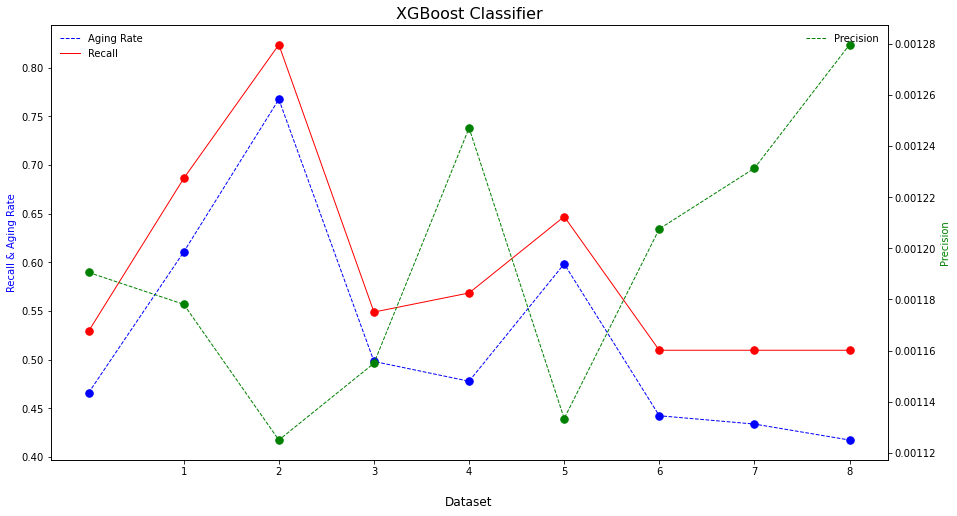

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset1,1.000000,3067.0,3067.0,27.0,22651.0,24.0,25947.0,0.001191,0.529412,0.466156,1.135698,0.001188,0.401714
dataset2,1.000000,2999.0,2999.0,35.0,29674.0,16.0,18924.0,0.001178,0.686275,0.610681,1.123786,0.001176,0.516902
dataset3,1.000000,3038.0,3038.0,42.0,37292.0,9.0,11306.0,0.001125,0.823529,0.767416,1.073121,0.001123,0.600398
dataset4,1.000000,3038.0,3038.0,28.0,24214.0,23.0,24384.0,0.001155,0.549020,0.498304,1.101776,0.001153,0.407802
dataset5,1.006623,3040.0,3020.0,29.0,23225.0,22.0,25373.0,0.001247,0.568627,0.477995,1.189609,0.001244,0.445646
dataset6,1.018425,3040.0,2985.0,33.0,29083.0,18.0,19515.0,0.001133,0.647059,0.598491,1.081150,0.001131,0.474243
dataset7,1.000000,3040.0,3040.0,26.0,21504.0,25.0,27094.0,0.001208,0.509804,0.442558,1.151948,0.001205,0.390700
dataset8,1.000000,3040.0,3040.0,26.0,21089.0,25.0,27509.0,0.001231,0.509804,0.434027,1.174589,0.001228,0.396036
dataset9,10.000000,3040.0,304.0,26.0,20291.0,25.0,28307.0,0.001280,0.509804,0.417624,1.220724,0.001277,0.406739


In [6]:
line_chart(table_setC, title = 'XGBoost Classifier')
table_setC

### Export

In [7]:
savedate = '20220601'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'XGBoost'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'XGBoost')